In [1]:
import scanpy as sc
import scvi
import muon as mu

In [2]:
mudata = mu.read("/home/icb/dominik.klein/git_repos/moscot_revisions/scMultiome_Mouse-Islets_NVF_E14-E16/scMultiome_Mouse-Islets_NVF_E14-E16_mdata_markedDoublets_mergedPeaks_normalized_rmDoublets.h5mu")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [3]:
adata = mudata["atac"].copy()

In [4]:
print("# regions before filtering:", adata.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions before filtering: 251676
# regions after filtering: 56582


In [5]:
scvi.external.POISSONVI.setup_anndata(adata, layer="atac_raw_counts", batch_key="sample")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
model = scvi.external.POISSONVI(adata, n_layers=4, n_latent=30)
model.train(max_epochs=25)


/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
You are using a CUDA device ('NVID

Epoch 25/25: 100%|██████████| 25/25 [01:29<00:00,  3.58s/it, v_num=1, train_loss_step=2.55e+4, train_loss_epoch=2.69e+4]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|██████████| 25/25 [01:29<00:00,  3.57s/it, v_num=1, train_loss_step=2.55e+4, train_loss_epoch=2.69e+4]


In [7]:
POISSONVI_LATENT_KEY = "X_poissonvi"

latent = model.get_latent_representation()
adata.obsm[POISSONVI_LATENT_KEY] = latent

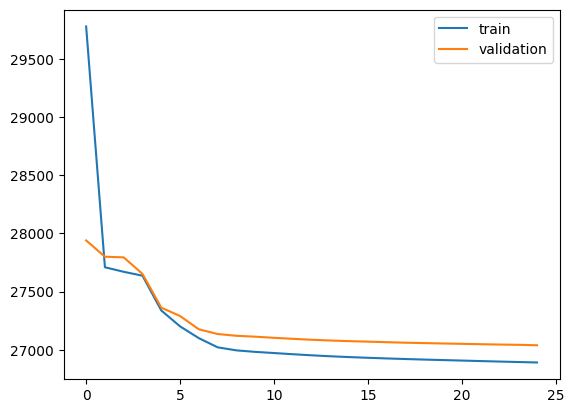

In [8]:
import matplotlib.pyplot as plt
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
plt.legend()

In [9]:
sc.pp.neighbors(adata, use_rep=POISSONVI_LATENT_KEY)
sc.tl.umap(adata)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


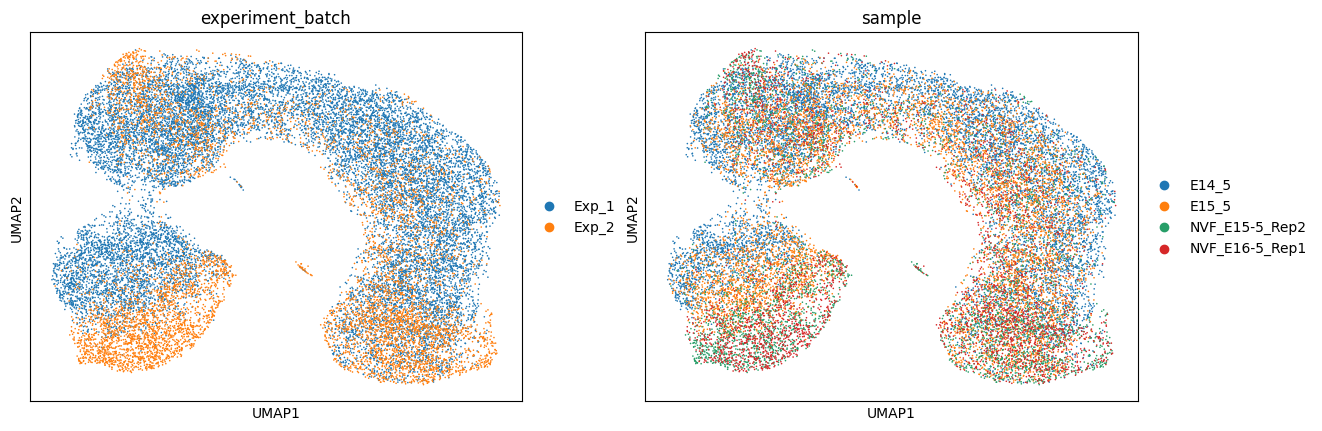

In [10]:
sc.pl.umap(adata, color=["experiment_batch", "sample"])

In [11]:
adata.layers["X_ATAC_reconstruction"] = model.get_accessibility_estimates(threshold=0.1, transform_batch="E15_5")

In [12]:
adata.X = adata.layers["X_ATAC_reconstruction"]
mu.atac.tl.lsi(adata)


In [13]:
import numpy as np
adata.obs["n_counts_ATAC_normalized"] = np.sum(adata.X, axis=1)

In [14]:
for i in range(49):
    print(np.corrcoef(adata.obsm["X_lsi"][:,i], adata.obs["n_counts_ATAC_normalized"])[0,1])

0.004513393633196841
0.005195696934746831
-0.0005068529593461323
-0.009389123314198928
-0.0012045869799445711
0.0013581893768572486
-0.0018097099899292235
0.00418105137679772
-0.012924745638517582
0.005843294689908749
-0.007585020341459156
-0.00016944789523545958
-0.0015273821963997529
0.000804770813194943
0.012528002567163818
0.011220779980518191
0.001058440897786521
0.011815091528554178
0.005477876152563798
0.003924321862603652
0.0037046136449080417
0.002939473307637407
-0.002379807647256644
-0.003943582168524796
-0.0024312609857087596
-0.0031271322023991677
0.00048738735879388446
0.009321501217265786
-0.0021194666339925095
-0.006305435334403203
-0.013433691476415694
-0.009244307923835416
-0.006709310746665161
-0.0010167566798814822
-0.006768500402338946
-0.0027682096155739098
0.0006584314462226235
0.003487509801197005
-0.0016274165586286442
-0.0034757222014899732
0.0035692760567287807
0.012112867322867246
-0.0026619339235285457
0.012265292699334171
-0.0028540308415030548
0.000708445

In [17]:
#to_keep = list(set(range(adata.obsm["X_lsi"].shape[1])) - {0, 1, 2})
#adata.obsm["X_lsi_red"] = adata.obsm["X_lsi"][:,to_keep]

In [16]:
sc.pp.neighbors(adata, use_rep="X_lsi")

In [17]:
sc.tl.umap(adata)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


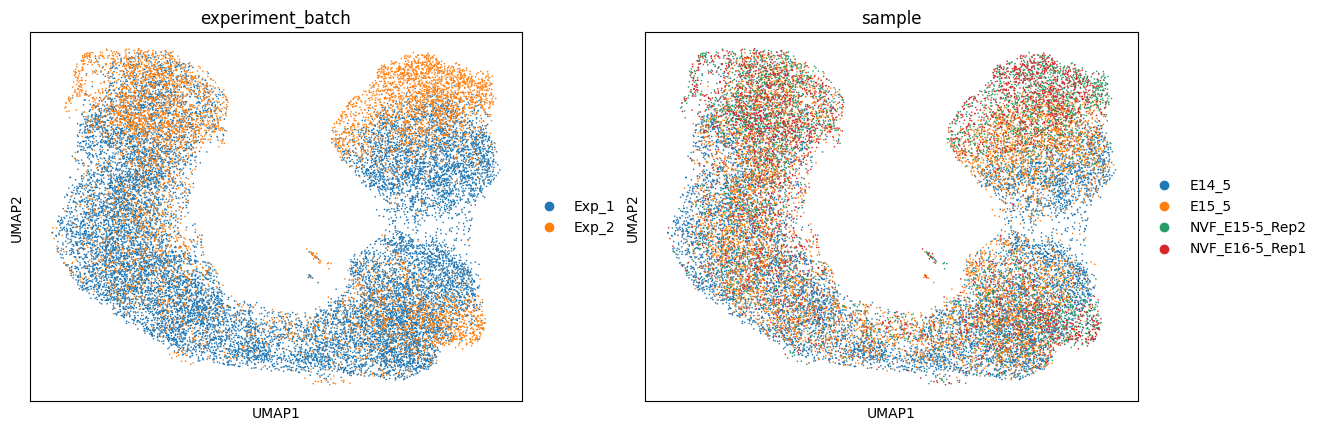

In [18]:
sc.pl.umap(adata,color=["experiment_batch", "sample"])

In [19]:
sc.tl.leiden(adata, resolution=0.6)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


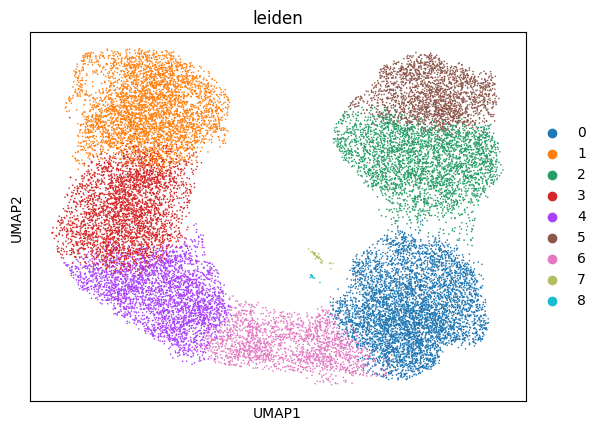

In [20]:
sc.pl.umap(adata, color="leiden")

In [21]:
mudata["rna"].obs["leiden_new"] = adata.obs["leiden"]

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


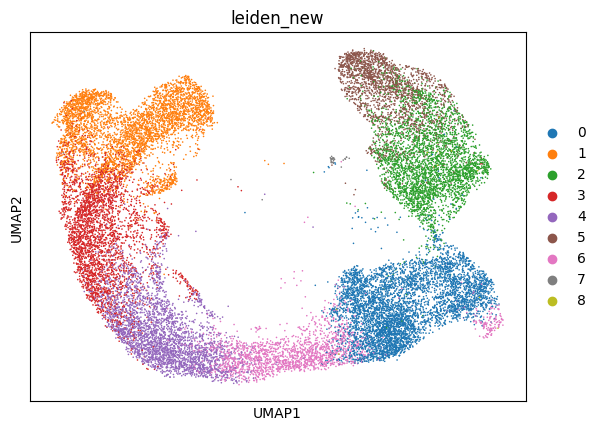

In [22]:
sc.pl.umap(mudata["rna"], color="leiden_new")

In [23]:
adata.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/adata_atac_PoissonVI_highly_variable.h5ad")